# Hollywood Actors Image Classification

### Problem Statement
- #### The main aim of this project is to classify images of the Hollywood Actors scrapped from google using opencv library and Machine Learning Algorithms

#### Importing Dependencies

In [1]:
! pip install opencv-python

In [2]:
! pip install PyWavelets

In [3]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Preprocessing: Detect face and eyes

#### When we look at any image, most of the time we identify a person using a face. An image might contain multiple faces, also the face can be obstructed and not clear. The first step in our pre-processing pipeline is to detect faces from an image. Once face is detected, we will detect eyes, if two eyes are detected then only we keep that image otherwise discard it.

In [4]:
img = cv2.imread('test_Images/brad_2.jpg')
img.shape

(2048, 1363, 3)

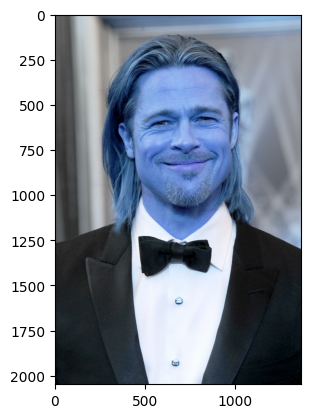

In [5]:
plt.imshow(img)

In [6]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray.shape

(2048, 1363)

In [7]:
gray

array([[ 98,  99,  98, ..., 184, 184, 184],
       [ 98,  99,  99, ..., 184, 184, 184],
       [ 98,  99,  99, ..., 184, 184, 184],
       ...,
       [  0,   0,   0, ...,   6,   5,   5],
       [  0,   0,   0, ...,   3,   2,   2],
       [  0,   0,   0, ...,   2,   2,   1]], dtype=uint8)

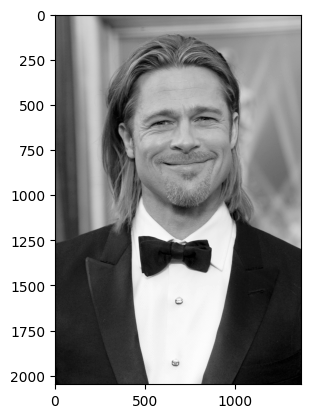

In [8]:
plt.imshow(gray,cmap='gray')

In [9]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces=face_cascade.detectMultiScale(gray,1.3,5)
faces

array([[382, 323, 673, 673]])

In [10]:
(x,y,w,h) = faces[0]
x,y,w,h

(382, 323, 673, 673)

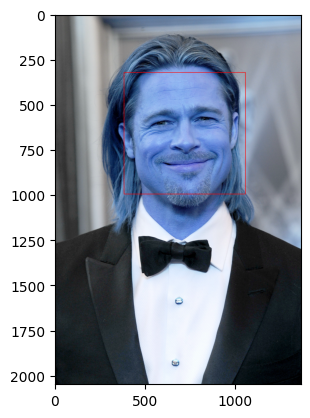

In [11]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

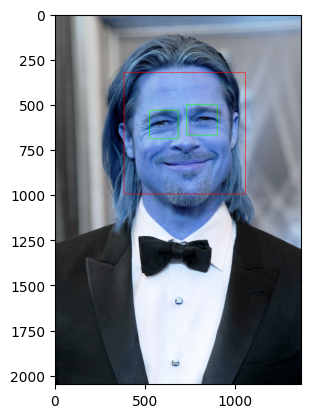

In [12]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

plt.figure()
plt.imshow(face_img,cmap='gray')
plt.show()

## Preprocessing: Crop the facial region of the image

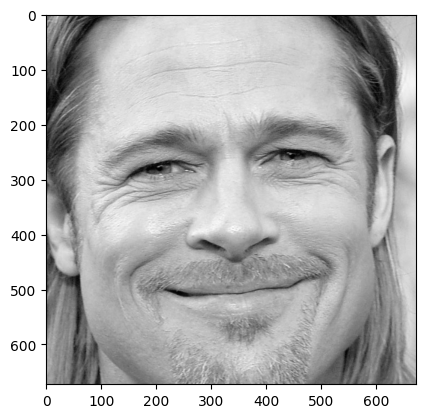

In [13]:
plt.imshow(roi_gray,cmap='gray')

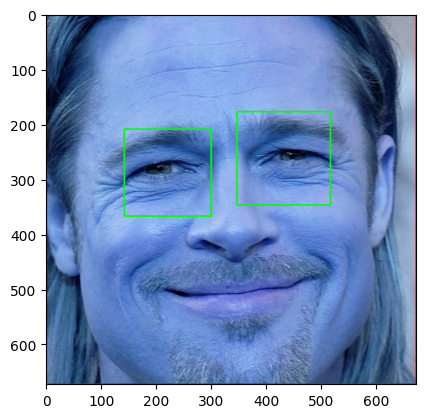

In [14]:
plt.imshow(roi_color,cmap='gray')

In [15]:
cropped_img = np.array(roi_color)
cropped_img.shape

(673, 673, 3)

## Preprocessing: Use wavelet transform as a feature for traning our model

### WAvelet Transform

In [16]:
import pywt

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)
    #print(coeffs)
    
    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H


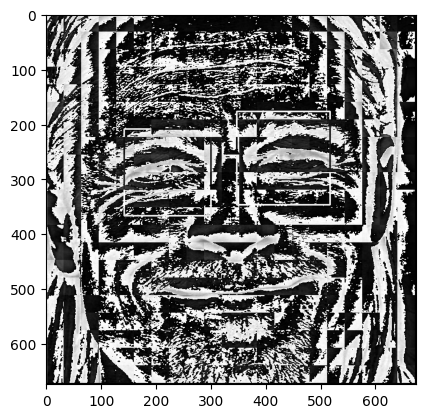

In [17]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

##### You can see above a wavelet transformed image that gives clues on facial features such as eyes, nose, lips etc. This along with raw pixel image can be used as an input for our classifier

## Preprocessing: Load image, detect face. If eyes >=2, then save and crop the face region

In [18]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h,x:x+w]
        roi_color = img[y:y+h,x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes)>=2:
            return roi_color

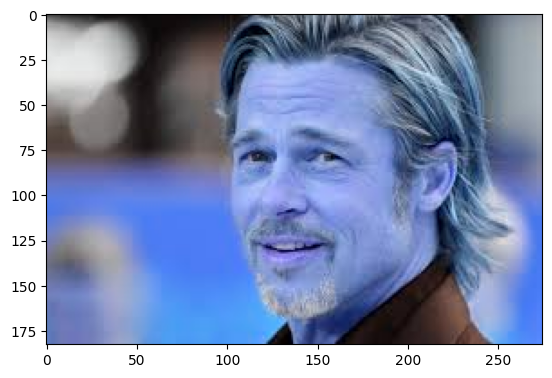

In [19]:
original_Image = cv2.imread('test_Images/brad_45.jpg')
plt.imshow(original_Image,cmap='gray')

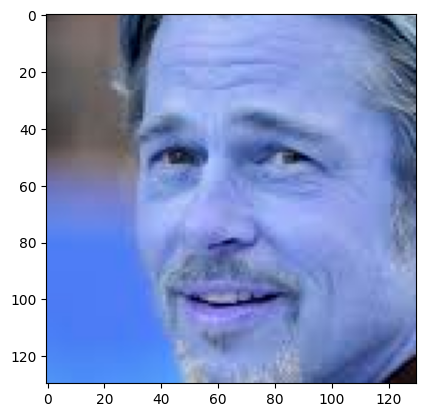

In [20]:
cropped_Image = get_cropped_image_if_2_eyes('test_Images/brad_45.jpg')
plt.imshow(cropped_Image)

#### In below image face is not very clear and it doesn't have two eyes clearly visible

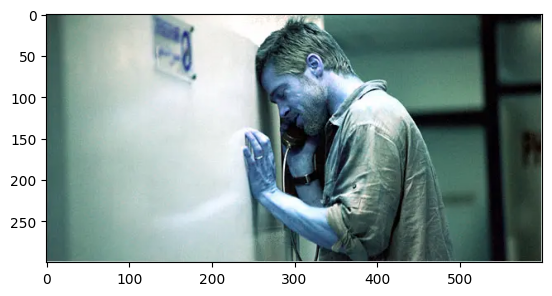

In [21]:
original_Image_obstructed = cv2.imread('test_Images/brad_67.jpg')
plt.imshow(original_Image_obstructed,cmap='gray')

In [22]:
cropped_Image_no_2_eyes = get_cropped_image_if_2_eyes('test_Images/brad_67.jpg')
cropped_Image_no_2_eyes # returns nothing as the eyes are not visible

##### Above cropped_image_no_2_eyes is None which means we should ignore this image and we will not use such image for model training

In [23]:
## Creating a path inside dataset directory for storing cropped images
path_to_data = "./dataset/"
path_to_cropped_data= "./dataset/cropped/"

In [24]:
# Creating a python list for all the folders in the dataset directory
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [25]:
img_dirs

['./dataset/brad_pitt',
 './dataset/chris_hemsworth',
 './dataset/dwayane_johnson',
 './dataset/leonardo_dicaprio',
 './dataset/will_smith']

##### Go through all images in dataset folder and create cropped images for them. There will be cropped folder inside dataset folder after you run this code

In [26]:
import shutil
if os.path.exists(path_to_cropped_data):
    shutil.rmtree(path_to_cropped_data)

os.mkdir(path_to_cropped_data)

In [27]:
cropped_image_dirs = []
celebrity_file_names_dict ={}

# iterate through all the paths and extract folders
for img_dir in img_dirs:
    count=1
    celebrity_name = img_dir.split('/')[-1]
    print (celebrity_name)
    
    celebrity_file_names_dict[celebrity_name] = [] # disctionary with each folder name
    
    # iterate through all the folders and then images inside the folders
    for entry in os.scandir(img_dir):
        # iterate through each images
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cropped_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)

            # Creating the name and path for each returned cropped images in each folder
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + '/' + cropped_file_name

            # Assigning the returned cropped image to its corresponding path
            cv2.imwrite(cropped_file_path,roi_color)

            # Assigning all the filepath in a dictionary
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count+=1



brad_pitt
Generating cropped images in folder:  ./dataset/cropped/brad_pitt
chris_hemsworth
Generating cropped images in folder:  ./dataset/cropped/chris_hemsworth
dwayane_johnson
Generating cropped images in folder:  ./dataset/cropped/dwayane_johnson
leonardo_dicaprio
Generating cropped images in folder:  ./dataset/cropped/leonardo_dicaprio
will_smith
Generating cropped images in folder:  ./dataset/cropped/will_smith


In [30]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'brad_pitt': ['./dataset/cropped/brad_pitt\\brad_pitt1.png',
  './dataset/cropped/brad_pitt\\brad_pitt10.png',
  './dataset/cropped/brad_pitt\\brad_pitt11.png',
  './dataset/cropped/brad_pitt\\brad_pitt12.png',
  './dataset/cropped/brad_pitt\\brad_pitt13.png',
  './dataset/cropped/brad_pitt\\brad_pitt14.png',
  './dataset/cropped/brad_pitt\\brad_pitt15.png',
  './dataset/cropped/brad_pitt\\brad_pitt16.png',
  './dataset/cropped/brad_pitt\\brad_pitt17.png',
  './dataset/cropped/brad_pitt\\brad_pitt18.png',
  './dataset/cropped/brad_pitt\\brad_pitt19.png',
  './dataset/cropped/brad_pitt\\brad_pitt2.png',
  './dataset/cropped/brad_pitt\\brad_pitt20.png',
  './dataset/cropped/brad_pitt\\brad_pitt21.png',
  './dataset/cropped/brad_pitt\\brad_pitt22.png',
  './dataset/cropped/brad_pitt\\brad_pitt23.png',
  './dataset/cropped/brad_pitt\\brad_pitt24.png',
  './dataset/cropped/brad_pitt\\brad_pitt25.png',
  './dataset/cropped/brad_pitt\\brad_pitt26.png',
  './dataset/cropped/brad_pitt\\brad_pi

In [31]:
class_dict={}
count=0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name]=count
    count = count + 1

class_dict

{'brad_pitt': 0,
 'chris_hemsworth': 1,
 'dwayane_johnson': 2,
 'leonardo_dicaprio': 3,
 'will_smith': 4}

### Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. Let's prepare X and y now

In [32]:
X , y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scaled_raw_img = cv2.resize(img,(32,32))
        img_har = w2d(img, 'db1',5)
        scaled_img_har = cv2.resize(im_har,(32,32))
        combined_img = np.vstack((scaled_raw_img.reshape(32*32*3,1),scaled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])

In [33]:
len(X)

187

In [34]:
len(X[0])

4096

In [35]:
X[0]

array([[ 61],
       [ 87],
       [117],
       ...,
       [247],
       [ 28],
       [251]], dtype=uint8)

In [36]:
y[0]

0

In [37]:
type(X)
X

[array([[ 61],
        [ 87],
        [117],
        ...,
        [247],
        [ 28],
        [251]], dtype=uint8),
 array([[ 47],
        [ 78],
        [102],
        ...,
        [247],
        [ 28],
        [251]], dtype=uint8),
 array([[101],
        [134],
        [159],
        ...,
        [247],
        [ 28],
        [251]], dtype=uint8),
 array([[ 42],
        [ 87],
        [112],
        ...,
        [247],
        [ 28],
        [251]], dtype=uint8),
 array([[ 31],
        [ 41],
        [ 59],
        ...,
        [247],
        [ 28],
        [251]], dtype=uint8),
 array([[ 74],
        [ 76],
        [ 77],
        ...,
        [247],
        [ 28],
        [251]], dtype=uint8),
 array([[ 14],
        [ 41],
        [ 68],
        ...,
        [247],
        [ 28],
        [251]], dtype=uint8),
 array([[136],
        [169],
        [212],
        ...,
        [247],
        [ 28],
        [251]], dtype=uint8),
 array([[ 34],
        [ 37],
        [ 49],
        ...

In [38]:
type(np.array(X))

numpy.ndarray

In [39]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(187, 4096)

In [40]:
X

array([[ 61.,  87., 117., ..., 247.,  28., 251.],
       [ 47.,  78., 102., ..., 247.,  28., 251.],
       [101., 134., 159., ..., 247.,  28., 251.],
       ...,
       [116., 118., 139., ..., 247.,  28., 251.],
       [136., 138., 163., ..., 247.,  28., 251.],
       [249., 237., 233., ..., 247.,  28., 251.]])

## Data cleaning process is done. Now we are ready to train our model

In [41]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()),('svc', SVC(kernel= 'rbf',C= 10))])
pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC(C=10))])

In [43]:
pipe.score(X_test,y_test)

0.7021276595744681

In [44]:
len(X_test)

47

In [45]:
len(X_train)

140

In [46]:
164*0.25

41.0

In [47]:
print(classification_report(y_test,pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.62      0.80      0.70        10
           1       0.62      0.71      0.67         7
           2       0.43      0.43      0.43         7
           3       0.78      0.64      0.70        11
           4       1.00      0.83      0.91        12

    accuracy                           0.70        47
   macro avg       0.69      0.68      0.68        47
weighted avg       0.73      0.70      0.71        47



### Using GridSearchCV

In [48]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [49]:
model_params = {
    'svm': {
        'model': SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
            
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
            
        }
    }
}

In [50]:
import pandas as pd
scores = []
best_estimators = {}
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(),mp['model'])
    clf = GridSearchCV(pipe, mp['params'],cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model' : algo,
        'best_score' : clf.best_score_,
        'best_params' : clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

df = pd.DataFrame(scores,columns = ['model', 'best_score', 'best_params'])
df

model  best_score  \
0                  svm    0.757143   
1        random_forest    0.514286   
2  logistic_regression    0.692857   

                                    best_params  
0        {'svc__C': 1, 'svc__kernel': 'linear'}  
1  {'randomforestclassifier__n_estimators': 10}  
2                  {'logisticregression__C': 1}

In [51]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [52]:
best_estimators['svm'].score(X_test,y_test)

0.723404255319149

In [53]:
best_estimators['random_forest'].score(X_test,y_test)

0.5531914893617021

In [54]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8297872340425532

#### Using Logistic Regression for model building and deployment

In [55]:
best_clf = best_estimators['logistic_regression']  # I will be using this model for deployment

In [56]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,best_clf.predict(X_test))
cm

array([[ 9,  0,  1,  0,  0],
       [ 0,  7,  0,  0,  0],
       [ 2,  0,  4,  0,  1],
       [ 1,  1,  1,  8,  0],
       [ 0,  0,  1,  0, 11]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

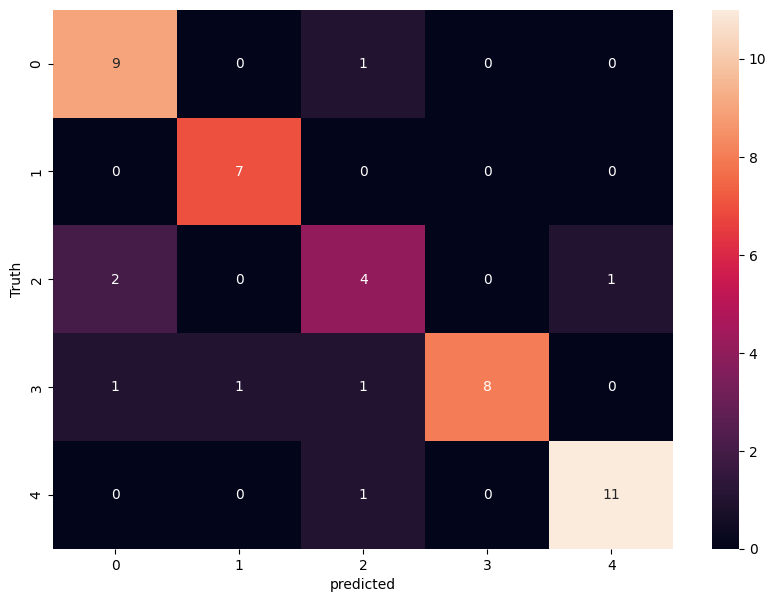

In [57]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('predicted')
plt.ylabel('Truth')

In [58]:
class_dict

{'brad_pitt': 0,
 'chris_hemsworth': 1,
 'dwayane_johnson': 2,
 'leonardo_dicaprio': 3,
 'will_smith': 4}

In [59]:
best_clf

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=1, solver='liblinear'))])

### Save the trained model

In [60]:
! pip install joblib
import joblib

joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

### Save class dictionary

In [61]:
import json
with open('class_dictionary.json','w') as f:
    f.write(json.dumps(class_dict))